In [140]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print(os.getcwd())
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models

C:\Users\Georgelele\PycharmProjects\Comp9444Proj1


loss function

In [141]:
# -----------------------------
# Loss functions
# -----------------------------
def dice_loss(pred, target, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).permute(0, 3, 1, 2).float() \
        if target.ndim == 3 else F.one_hot(target, num_classes=pred.size(1)).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2. * intersection + epsilon) / (union + epsilon)

def focal_loss(pred, target, alpha=0.75, gamma=2):
    ce_loss = F.cross_entropy(pred, target, reduction='none')
    pt = torch.exp(-ce_loss)
    focal = alpha * (1 - pt) ** gamma * ce_loss
    return focal.mean()

def tversky_loss(pred, target, alpha=0.7, beta=0.3, epsilon=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = F.one_hot(target, num_classes=pred.size(1)).float()
    tp = (pred * target).sum()
    fp = ((1 - target) * pred).sum()
    fn = (target * (1 - pred)).sum()
    return 1 - (tp + epsilon) / (tp + alpha * fp + beta * fn + epsilon)

def combo_loss(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * dice_loss(pred, target)

def focal_tversky_combo(pred, target):
    return 0.5 * focal_loss(pred, target) + 0.5 * tversky_loss(pred, target)

def select_loss(loss_type):
    if loss_type == "dice":
        return dice_loss
    elif loss_type == "focal":
        return focal_loss
    elif loss_type == "tversky":
        return tversky_loss
    elif loss_type == "focal+dice":
        return combo_loss
    elif loss_type == "focal+tversky":
        return focal_tversky_combo
    else:
        raise ValueError(f"Unsupported loss function: {loss_type}")


resnet50

In [142]:
# -----------------------------
# resnet50
# -----------------------------


def get_resnet_classifier(num_classes=5, pretrained=True):
    model = models.resnet50(weights="IMAGENET1K_V1" if pretrained else None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

Metrics Plotting

In [143]:
# -----------------------------
# Metrics Plotting
# -----------------------------
def plot_metrics(history, save_dir, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)
    plt.figure()
    plt.plot(epochs, history["acc"], label="Accuracy")
    plt.plot(epochs, history["precision"], label="Precision")
    plt.plot(epochs, history["recall"], label="Recall")
    plt.plot(epochs, history["f1"], label="F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics Over Epochs")
    plt.legend()
    plt.grid(True)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "metrics_curve.png"))
    if show_inline:
        plt.show()
    plt.close()


def plot_per_class_metrics(history, class_names, save_dir, show_inline=True):
    epochs = range(1, len(history["acc"]) + 1)

    for metric in ["precision", "recall", "f1"]:
        plt.figure(figsize=(8, 6))
        for i, cls_name in enumerate(class_names):
            plt.plot(epochs, history["per_class"][i][metric], label=cls_name)
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.title(f"Per-Class {metric.capitalize()} Over Epochs")
        plt.legend()
        plt.grid(True)
        if save_dir:
            plt.savefig(os.path.join(save_dir, f"per_class_{metric}.png"))
        if show_inline:
            plt.show()
        plt.close()


def plot_confusion(y_true, y_pred, class_names, save_dir):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.close()

Training Loop

In [144]:
# -----------------------------
# Training Loop with Args
# -----------------------------
def train_model(model, train_loader, val_loader, device, args, class_names):
    model = model.to(device)

    # ✅ Select optimizer based on args
    if args.optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=args.lr)
    elif args.optimizer == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=1e-4)
    elif args.optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError(f"Unsupported optimizer: {args.optimizer}")

    # ✅ Select loss from args
    loss_fn = select_loss(args.loss)

    history = {
        "acc": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "per_class": {i: {"precision": [], "recall": [], "f1": []} for i in range(len(class_names))}
    }

    best_acc = 0

    for epoch in range(args.epochs):
        # -----------------------------
        # Training
        # -----------------------------
        model.train()
        total_loss, correct, total = 0, 0, 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{args.epochs} [Train]", unit="batch")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({"loss": f"{loss.item():.4f}",
                              "acc": f"{(correct / total):.4f}"})

        train_acc = correct / total
        print(f"[Train] Epoch {epoch+1}: Loss={total_loss/total:.4f}, Acc={train_acc:.4f}")

        # -----------------------------
        # Validation
        # -----------------------------
        model.eval()
        y_true, y_pred = [], []
        val_loss, val_correct, val_total = 0, 0, 0
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{args.epochs} [Val]", unit="batch")
        with torch.no_grad():
            for imgs, labels in pbar_val:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                preds = outputs.argmax(1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

                val_loss += loss.item() * labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

                pbar_val.set_postfix({"loss": f"{loss.item():.4f}",
                                      "acc": f"{(val_correct/val_total):.4f}"})

        # -----------------------------
        # Metrics Calculation
        # -----------------------------
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), average="macro", zero_division=0
        )
        acc = np.mean(np.array(y_true) == np.array(y_pred))
        history["acc"].append(acc)
        history["precision"].append(precision_macro)
        history["recall"].append(recall_macro)
        history["f1"].append(f1_macro)

        # Per-class metrics
        precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(
            y_true, y_pred, labels=list(range(len(class_names))), zero_division=0
        )
        for i, cls_name in enumerate(class_names):
            history["per_class"][i]["precision"].append(precision_cls[i])
            history["per_class"][i]["recall"].append(recall_cls[i])
            history["per_class"][i]["f1"].append(f1_cls[i])

        print(
            f"[Val] Epoch {epoch + 1}: Acc={acc:.4f}, Precision={precision_macro:.4f}, Recall={recall_macro:.4f}, F1={f1_macro:.4f}")

        # Save best model & confusion matrix
        if acc > best_acc:
            best_acc = acc
            os.makedirs(args.save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(args.save_dir, "best_model.pth"))
            plot_confusion("Val", y_true, y_pred, class_names, args.save_dir)

            print(f"✅ Best model saved at epoch {epoch+1} with Acc={acc:.4f}")

    # -----------------------------
    # Save plots after training
    # -----------------------------
    plot_metrics(history, args.save_dir)
    plot_per_class_metrics(history, class_names, args.save_dir)


Args

In [145]:
import argparse, sys, torch

def get_args():
    parser = argparse.ArgumentParser(description="Train ResNet Classifier on Custom Dataset")
    parser.add_argument("--data_dir", type=str, required=True, help="Path to dataset")
    parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training")
    parser.add_argument("--lr", type=float, default=1e-4, help="Learning rate")
    parser.add_argument("--optimizer", type=str, default="adamw", 
                        choices=["adam", "adamw", "sgd"], help="Optimizer type")
    parser.add_argument("--loss", type=str, default="focal+tversky",
                        choices=["dice", "focal", "tversky", "focal+dice", "focal+tversky"],
                        help="Loss function")
    parser.add_argument("--img_size", type=int, default=224, help="Input image size (square)")
    parser.add_argument("--num_workers", type=int, default=4, help="Number of DataLoader workers")
    parser.add_argument("--save_dir", type=str, default="results", help="Directory to save outputs")
    parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        help="Training device")

    args = parser.parse_args(sys.argv[1:])  # works in Jupyter after cleaning sys.argv in launcher
    return args


Plot

In [146]:
# -----------------------------
# Plotting
# -----------------------------
def plot_global(history, save_dir):
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curve'); plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'loss_curve.png'))
    plt.close()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'],   label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend(); plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'accuracy_curve.png'))
    plt.close()


def plot_per_class_metrics(history, class_names, save_dir):
    epochs = range(1, len(history["acc"]) + 1)

    for metric in ["precision", "recall", "f1"]:
        for i, cls_name in enumerate(class_names):
            plt.figure(figsize=(7, 5))
            plt.plot(epochs, history["per_class"][i][metric], marker='o')
            plt.xlabel("Epoch")
            plt.ylabel(metric.capitalize())
            plt.title(f"{cls_name} - {metric.capitalize()} Over Epochs")
            plt.grid(True)
            plt.savefig(os.path.join(save_dir, f"{cls_name}_{metric}.png"))
            plt.close()



def plot_confusion(name, y_true, y_pred, classes, save_dir="results"):
    cm = confusion_matrix(y_true, y_pred)
    os.makedirs(save_dir, exist_ok=True)  # make sure dir exists
    plt.figure(figsize=(len(classes)*1.2, len(classes)*1.2))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion Matrix ({name})')
    plt.savefig(os.path.join(save_dir, f'confusion_{name}.png'))
    plt.close()


In [147]:
def main():
    args = get_args()

    run_name = f"epochs{args.epochs}_bs{args.batch_size}_lr{args.lr}_loss{args.loss}_img{args.img_size}"
    run_name = run_name.replace("+", "_")  # ✅ sanitize for Windows paths
    args.save_dir = os.path.join(args.save_dir, run_name)
    os.makedirs(args.save_dir, exist_ok=True)

    if not os.path.isdir(args.data_dir):
        raise RuntimeError(f"❌ Dataset path not found: {args.data_dir}")
    print("✅ Using dataset:", args.data_dir)

    transform = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
    ])

    train_data = datasets.ImageFolder(os.path.join(args.data_dir, "train"), transform=transform)
    val_data   = datasets.ImageFolder(os.path.join(args.data_dir, "val"), transform=transform)

    train_loader = DataLoader(train_data,
                              batch_size=args.batch_size,
                              shuffle=True,
                              num_workers=args.num_workers,
                              pin_memory=True)

    val_loader = DataLoader(val_data,
                            batch_size=args.batch_size,
                            shuffle=False,
                            num_workers=args.num_workers,
                            pin_memory=True)

    class_names = train_data.classes
    print("Classes:", class_names)

    device = torch.device(args.device)
    model = get_resnet_classifier(num_classes=len(class_names))

    print(f"Using loss function: {args.loss}")
    loss_fn = select_loss(args.loss)

    train_model(model, train_loader, val_loader, device, args, class_names)


Launching with: ['--data_dir', 'C:\\Users\\Georgelele\\PycharmProjects\\Comp9444Proj1\\dataset', '--epochs', '10', '--batch_size', '8', '--lr', '5e-4', '--img_size', '512', '--optimizer', 'adamw', '--num_workers', '4', '--save_dir', 'runs', '--loss', 'focal+dice']
✅ Using dataset: C:\Users\Georgelele\PycharmProjects\Comp9444Proj1\dataset
Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp']
Using loss function: focal+dice


Epoch 1/10 [Train]: 100%|██████████| 553/553 [01:10<00:00,  7.86batch/s, loss=0.1301, acc=0.6907]


[Train] Epoch 1: Loss=0.4040, Acc=0.6907


Epoch 1/10 [Val]: 100%|██████████| 69/69 [00:17<00:00,  3.88batch/s, loss=0.1705, acc=0.7327]


[Val] Epoch 1: Acc=0.7327, Precision=0.6359, Recall=0.5036, F1=0.4566
✅ Best model saved at epoch 1 with Acc=0.7327


Epoch 2/10 [Train]: 100%|██████████| 553/553 [01:06<00:00,  8.29batch/s, loss=0.2107, acc=0.7825]


[Train] Epoch 2: Loss=0.2927, Acc=0.7825


Epoch 2/10 [Val]: 100%|██████████| 69/69 [00:19<00:00,  3.61batch/s, loss=0.1759, acc=0.8255]


[Val] Epoch 2: Acc=0.8255, Precision=0.8028, Recall=0.6074, F1=0.6248
✅ Best model saved at epoch 2 with Acc=0.8255


Epoch 3/10 [Train]: 100%|██████████| 553/553 [01:14<00:00,  7.42batch/s, loss=0.1066, acc=0.8069]


[Train] Epoch 3: Loss=0.2535, Acc=0.8069


Epoch 3/10 [Val]: 100%|██████████| 69/69 [00:16<00:00,  4.10batch/s, loss=0.1398, acc=0.7800]


[Val] Epoch 3: Acc=0.7800, Precision=0.7296, Recall=0.5939, F1=0.5915


Epoch 4/10 [Train]: 100%|██████████| 553/553 [01:08<00:00,  8.08batch/s, loss=0.2457, acc=0.8284]


[Train] Epoch 4: Loss=0.2208, Acc=0.8284


Epoch 4/10 [Val]: 100%|██████████| 69/69 [00:19<00:00,  3.62batch/s, loss=0.2673, acc=0.8436]


[Val] Epoch 4: Acc=0.8436, Precision=0.7760, Recall=0.6379, F1=0.6745
✅ Best model saved at epoch 4 with Acc=0.8436


Epoch 5/10 [Train]: 100%|██████████| 553/553 [01:17<00:00,  7.13batch/s, loss=0.0772, acc=0.8424]


[Train] Epoch 5: Loss=0.2068, Acc=0.8424


Epoch 5/10 [Val]: 100%|██████████| 69/69 [00:18<00:00,  3.67batch/s, loss=0.6175, acc=0.7818]


[Val] Epoch 5: Acc=0.7818, Precision=0.6740, Recall=0.6554, F1=0.6058


Epoch 6/10 [Train]: 100%|██████████| 553/553 [01:16<00:00,  7.24batch/s, loss=0.3124, acc=0.8610]


[Train] Epoch 6: Loss=0.1845, Acc=0.8610


Epoch 6/10 [Val]: 100%|██████████| 69/69 [00:18<00:00,  3.69batch/s, loss=0.1168, acc=0.8491]


[Val] Epoch 6: Acc=0.8491, Precision=0.8109, Recall=0.6139, F1=0.6383
✅ Best model saved at epoch 6 with Acc=0.8491


Epoch 7/10 [Train]: 100%|██████████| 553/553 [01:16<00:00,  7.19batch/s, loss=0.1672, acc=0.8628]


[Train] Epoch 7: Loss=0.1817, Acc=0.8628


Epoch 7/10 [Val]: 100%|██████████| 69/69 [00:21<00:00,  3.26batch/s, loss=0.3037, acc=0.8309]


[Val] Epoch 7: Acc=0.8309, Precision=0.7220, Recall=0.7196, F1=0.6956


Epoch 8/10 [Train]: 100%|██████████| 553/553 [01:18<00:00,  7.06batch/s, loss=0.0640, acc=0.8849]


[Train] Epoch 8: Loss=0.1576, Acc=0.8849


Epoch 8/10 [Val]: 100%|██████████| 69/69 [00:21<00:00,  3.15batch/s, loss=0.3391, acc=0.8709]


[Val] Epoch 8: Acc=0.8709, Precision=0.7730, Recall=0.7767, F1=0.7386
✅ Best model saved at epoch 8 with Acc=0.8709


Epoch 9/10 [Train]: 100%|██████████| 553/553 [01:19<00:00,  7.00batch/s, loss=0.0248, acc=0.8915]


[Train] Epoch 9: Loss=0.1401, Acc=0.8915


Epoch 9/10 [Val]: 100%|██████████| 69/69 [00:20<00:00,  3.30batch/s, loss=0.1231, acc=0.7782]


[Val] Epoch 9: Acc=0.7782, Precision=0.7304, Recall=0.6782, F1=0.6871


Epoch 10/10 [Train]: 100%|██████████| 553/553 [01:18<00:00,  7.08batch/s, loss=0.1161, acc=0.9005]


[Train] Epoch 10: Loss=0.1335, Acc=0.9005


Epoch 10/10 [Val]: 100%|██████████| 69/69 [00:20<00:00,  3.30batch/s, loss=0.1253, acc=0.8400]

[Val] Epoch 10: Acc=0.8400, Precision=0.7381, Recall=0.8199, F1=0.7623


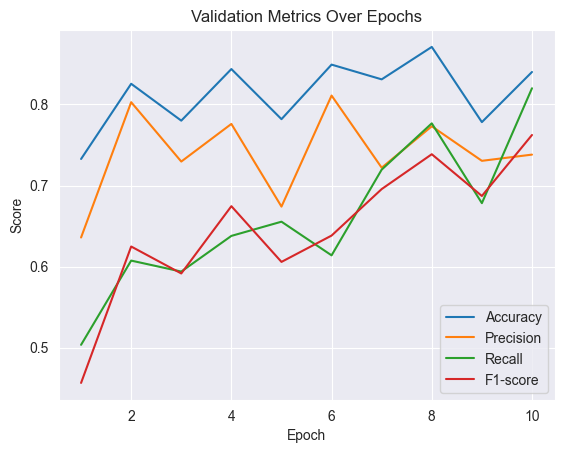

In [148]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "dataset"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "10",
    "--batch_size", "8",
    "--lr", "5e-4",
    "--img_size", "512",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+dice",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


In [ ]:
import sys, os

# clear Jupyter's own args
sys.argv = sys.argv[:1]

dataset_path = os.path.abspath(os.path.join(os.getcwd(), "dataset"))
if not os.path.isdir(dataset_path):
    raise RuntimeError(f"❌ Dataset folder not found at {dataset_path}")

sys.argv += [
    "--data_dir", dataset_path,
    "--epochs", "10",
    "--batch_size", "8",
    "--lr", "5e-4",
    "--img_size", "512",
    "--optimizer", "adamw",
    "--num_workers", "4",
    "--save_dir", "runs",
    "--loss", "focal+dice",  # ✅ matches parser
]

print("Launching with:", sys.argv[1:])
main()


2  EfficientNet-B0

In [1]:
import argparse, copy, time, torch, os
from pathlib import Path
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.metrics import classification_report, confusion_matrix


DATA_ROOT = Path(r"/Users/invoker/Downloads/Dataset")    
IMG_SIZE   = 224
MEAN, STD  = [0.485,0.456,0.406], [0.229,0.224,0.225]
BATCH      = 32
NUM_WORKERS = 4     
PIN_MEMORY  = False  # True on CUDA GPUs

def get_loaders(batch=BATCH):
    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE,(0.8,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.1,0.1,0.1,0.05),
        transforms.ToTensor(), transforms.Normalize(MEAN,STD)])
    eval_tfms  = transforms.Compose([
        transforms.Resize(int(IMG_SIZE*1.14)), transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(), transforms.Normalize(MEAN,STD)])
    train_ds = datasets.ImageFolder(DATA_ROOT/"train", train_tfms)
    val_ds   = datasets.ImageFolder(DATA_ROOT/"val",   eval_tfms)
    test_ds  = datasets.ImageFolder(DATA_ROOT/"test",  eval_tfms)
    kw = dict(batch_size=batch, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    return (DataLoader(train_ds, shuffle=True,  **kw),
            DataLoader(val_ds,   shuffle=False, **kw),
            DataLoader(test_ds,  shuffle=False, **kw),
            train_ds.classes)


model&train

In [2]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps"  if torch.backends.mps.is_available()
                      else "cpu")

train_dl, val_dl, test_dl, classes = get_loaders()

weights = EfficientNet_B0_Weights.IMAGENET1K_V1
model = efficientnet_b0(weights=weights)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(classes))
model.to(device)

EPOCHS   = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {"train_acc":[], "val_acc":[], "train_loss":[], "val_loss":[]}
best_w, best_acc = copy.deepcopy(model.state_dict()), 0.0

for epoch in range(EPOCHS):
    t0 = time.time(); model.train()
    tr_loss = correct = total = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x); loss = criterion(out, y)
        loss.backward(); optimizer.step()
        tr_loss += loss.item()*x.size(0)
        correct += out.argmax(1).eq(y).sum().item(); total += y.size(0)
    tr_loss /= total; tr_acc = correct/total

    # validation
    model.eval(); val_loss = correct = total = 0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            out = model(x); val_loss += criterion(out, y).item()*x.size(0)
            correct += out.argmax(1).eq(y).sum().item(); total += y.size(0)
    val_loss /= total; val_acc = correct/total
    scheduler.step()

    history["train_acc"].append(tr_acc); history["val_acc"].append(val_acc)
    history["train_loss"].append(tr_loss); history["val_loss"].append(val_loss)

    if val_acc > best_acc:
        best_acc, best_w = val_acc, copy.deepcopy(model.state_dict())

    print(f"Ep {epoch+1:02}/{EPOCHS} "
          f"tr_acc={tr_acc:.3f} val_acc={val_acc:.3f} "
          f"({time.time()-t0:.1f}s)")

model.load_state_dict(best_w)


Ep 01/10 tr_acc=0.778 val_acc=0.872 (75.0s)
Ep 02/10 tr_acc=0.875 val_acc=0.910 (73.4s)
Ep 03/10 tr_acc=0.905 val_acc=0.910 (73.5s)
Ep 04/10 tr_acc=0.915 val_acc=0.915 (73.6s)
Ep 05/10 tr_acc=0.927 val_acc=0.914 (73.4s)
Ep 06/10 tr_acc=0.937 val_acc=0.923 (73.5s)
Ep 07/10 tr_acc=0.945 val_acc=0.921 (73.7s)
Ep 08/10 tr_acc=0.950 val_acc=0.923 (73.3s)
Ep 09/10 tr_acc=0.955 val_acc=0.925 (73.5s)
Ep 10/10 tr_acc=0.956 val_acc=0.929 (71.5s)


<All keys matched successfully>

Confusion matrix and class accuracy 

In [3]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in test_dl:
        logits = model(x.to(device))
        y_true.extend(y.numpy())
        y_pred.extend(logits.argmax(1).cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:")
print(cm)

acc_per_class = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, acc_per_class):
    print(f"{cls:<15s}: {acc*100:5.1f}%")


Confusion matrix:
[[224   4   0   1]
 [ 10  26   7   0]
 [  2   7 163  10]
 [  1   0   5  79]]
Adenocarcinoma :  97.8%
High-grade IN  :  60.5%
Low-grade IN   :  89.6%
Polyp          :  92.9%


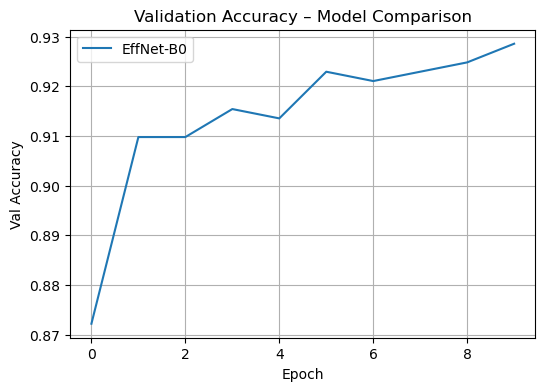

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history['val_acc'],       label='EffNet-B0')
plt.xlabel('Epoch'); plt.ylabel('Val Accuracy'); plt.legend(); plt.grid(True)
plt.title('Validation Accuracy – Model Comparison')
plt.show()
